# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Data

## Dados cadastrais

In [63]:
info_cadastro = pd.read_csv('../data/fundos/cad_fi.csv', encoding='ISO-8859-1', sep=';')

/tmp/ipykernel_5842/4102126748.py:1: DtypeWarning: Columns (14,17,18,20,22,24,27,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  info_cadastro = pd.read_csv('../data/fundos/cad_fi.csv', encoding='ISO-8859-1', sep=';')


In [5]:
info_cadastro.head()

,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,ADMIN,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR
0,FACFIF,00.000.684/0001-21,DEUTSCHE BANK FDO APLIC QUOTAS FDO INV FINANCE...,2003-04-30,1994-12-20,19.0,2000-08-01,CANCELADA,2000-08-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FACFIF,00.000.731/0001-37,ITAMARITI CASH FUNDO APLICACAO QUOTAS FDOS INV...,2003-04-30,1994-05-18,40681.0,1996-01-26,CANCELADA,1996-01-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FACFIF,00.000.732/0001-81,FUNDO APLIC. QUOTAS DE F.I. SANTANDER CURTO PRAZO,2003-04-30,1994-05-24,27.0,1999-09-03,CANCELADA,1999-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FACFIF,00.000.740/0001-28,FUNDO DE APLIC EM QUOTAS DE FUNDOS DE INV BMC ...,2003-04-30,1994-05-23,40690.0,1996-06-10,CANCELADA,1996-06-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACFIF,00.000.749/0001-39,BALANCE FUNDO APLICACAO QUOTAS FUNDO INVESTIME...,2003-04-30,1994-05-12,35.0,2000-06-26,CANCELADA,2000-06-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Histórico

In [36]:
# Último mês completo
fundos_2022_12 = pd.read_csv('../data/fundos/inf_diario/inf_diario_fi_2022/inf_diario_fi_202212.csv', 
                             encoding='ISO-8859-1', sep=';')

In [41]:
# Média de 1000 cotistas em Dezembro de 2022
cnpj_valido = fundos_2022_12.groupby('CNPJ_FUNDO').mean(numeric_only=True).query('NR_COTST >= 1000').index

In [57]:
# Leitura do histórico
df_fundos = pd.DataFrame()
paths = glob.glob('../data/fundos/inf_diario/*')
for path in paths:
    files = glob.glob(f'{path}/*.csv')
    for file in files:
        df_temp = pd.read_csv(file, encoding='ISO-8859-1', sep=';')
        df_temp = df_temp[df_temp['CNPJ_FUNDO'].isin(cnpj_valido)]
        df_fundos = pd.concat([df_fundos, df_temp])
        print('Added file: ' + file)

Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202002.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202010.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202012.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202009.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202003.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202004.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202006.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202007.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202011.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202005.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202008.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2020/inf_diario_fi_202001.csv
Added file: ../d

Added file: ../data/fundos/inf_diario/inf_diario_fi_2019/inf_diario_fi_201912.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2019/inf_diario_fi_201907.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2019/inf_diario_fi_201909.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2019/inf_diario_fi_201908.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2019/inf_diario_fi_201904.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2019/inf_diario_fi_201910.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2019/inf_diario_fi_201903.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2019/inf_diario_fi_201911.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2011/inf_diario_fi_201107.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2011/inf_diario_fi_201106.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2011/inf_diario_fi_201108.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2011/inf_diario_fi_201105.csv
Added file: ../d

Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200905.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200912.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200903.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200901.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200906.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200907.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200911.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200910.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2009/inf_diario_fi_200909.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2016/inf_diario_fi_201606.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2016/inf_diario_fi_201607.csv
Added file: ../data/fundos/inf_diario/inf_diario_fi_2016/inf_diario_fi_201601.csv
Added file: ../d

In [61]:
# Conversão de data
df_fundos['DT_COMPTC'] = pd.to_datetime(df_fundos['DT_COMPTC'])

In [65]:
# Adição da denominação social
df_fundos_nominacao = df_fundos.merge(info_cadastro[['CNPJ_FUNDO', 'DENOM_SOCIAL']], how='left', on='CNPJ_FUNDO')

In [68]:
# Ordenando pela data e dnominação social
df_fundos_nominacao.sort_values(['DT_COMPTC', 'DENOM_SOCIAL'], inplace=True)

In [81]:
# Exclusão dos fundos com denominação social igual a nan
df_fundos_nominacao_valido = df_fundos_nominacao[~df_fundos_nominacao['DENOM_SOCIAL'].isna()].copy()

In [84]:
# Histórico exemplo
aux = df_fundos_nominacao_valido[df_fundos_nominacao_valido['CNPJ_FUNDO'] == '00.601.692/0001-23']

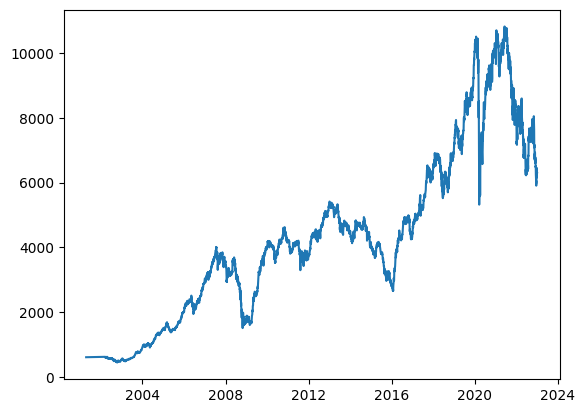

In [88]:
plt.plot(aux['DT_COMPTC'], aux['VL_QUOTA'])

# Data Output

In [98]:
# Renomeação das colunas
df_fundos_nominacao_valido.columns = df_fundos_nominacao_valido.columns.str.lower()

In [101]:
# Seleção e ordenação das columnas
df_fundos_nominacao_valido = df_fundos_nominacao_valido[['dt_comptc', 'cnpj_fundo', 'denom_social', 'vl_quota', 
                                                         'vl_patrim_liq', 'captc_dia', 'resg_dia', 
                                                         'nr_cotst']].to_csv('../data/fundos.csv', index=False)

In [ ]:
# Geração do arquivo histórico até 2022-12
df_fundos_nominacao_valido.to_csv('../data/fundos.csv', index=False)